**구글 드라이브 마운트**

In [2]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


구글 드라이브에 cartech-100 압축 파일 업로드  
(BACKGROUND_Google 파일 삭제 후 압축)


**압축 파일 해제 및 폴더 개수 확인**

In [3]:
import zipfile
import os
import shutil

# ZIP 파일 경로 (Google Drive)
zip_path = "/content/drive/MyDrive/caltech-101/101_ObjectCategories.zip"
extract_path = "/content/caltech-101"

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료")

# 압축 해제된 폴더 경로 설정
data_path = os.path.join(extract_path, "101_ObjectCategories")

# 추가된 폴더 제거
extra_folders = ["__MACOSX", ".ipynb_checkpoints", "BACKGROUND_Google"]
for folder in extra_folders:
    folder_path = os.path.join(data_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"{folder} 폴더 삭제 완료")

# 최종 폴더 개수 확인
folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
print(f"최종 클래스 폴더 개수: {len(folders)}")
print(f"예제 폴더: {folders[:5]}")  # 앞에서 5개만 출력

압축 해제 완료!
최종 클래스 폴더 개수: 101
예제 폴더: ['pyramid', 'cannon', 'ceiling_fan', 'hawksbill', 'bass']


**훈련, 검증, 테스트 데이터 분할 (80%, 10%, 10%)**

In [4]:
import os
import random
from shutil import copy2

# 원본 데이터 경로
data_path = "/content/caltech-101/101_ObjectCategories"
train_path = "/content/caltech-101/train"
val_path = "/content/caltech-101/val"
test_path = "/content/caltech-101/test"

# 폴더 생성
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# 데이터 비율 설정
train_ratio = 0.8  # 전체 데이터 중 80%를 Train으로 사용
val_ratio = 0.1  # 전체 데이터 중 10%를 Validation으로 사용
test_ratio = 0.1  # 전체 데이터 중 10%를 Test로 사용

for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)

    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        random.shuffle(images)  # 랜덤 셔플

        train_split_idx = int(len(images) * train_ratio)
        val_split_idx = int(len(images) * (train_ratio + val_ratio))

        train_images = images[:train_split_idx]
        val_images = images[train_split_idx:val_split_idx]
        test_images = images[val_split_idx:]

        os.makedirs(os.path.join(train_path, category), exist_ok=True)
        os.makedirs(os.path.join(val_path, category), exist_ok=True)
        os.makedirs(os.path.join(test_path, category), exist_ok=True)

        for img in train_images:
            copy2(os.path.join(category_path, img), os.path.join(train_path, category, img))

        for img in val_images:
            copy2(os.path.join(category_path, img), os.path.join(val_path, category, img))

        for img in test_images:
            copy2(os.path.join(category_path, img), os.path.join(test_path, category, img))

print("데이터 분할 완료: 80% Train, 10% Val, 10% Test")

데이터 분할 완료: 80% Train, 10% Val, 10% Test


**평균, 표준편차 계산 (평균과 표준 편차를 이용한 정규화 -> Z-score)**

In [26]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 정규화 없이 로드 (mean, std 계산용)
# 정규화된 데이터는 평균과 표준편차 계산에 왜곡을 줄 수 있음
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 로드
data_path = "/content/caltech-101/101_ObjectCategories"
dataset = datasets.ImageFolder(root=data_path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2) # 32개 배치 단위로 불러옴

# Mean, Std 계산
# RGB 3채널 각각의 평균과 표준편차를 저장할 공간 생성
mean = torch.zeros(3)
std = torch.zeros(3)
# 전체 샘플 개수를 저장할 변수
num_samples = 0

# 각 채널에 대해 모든 픽셀을 1차원 벡터로 펼침
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, 3, -1)

    mean += images.mean(dim=[0, 2])
    std += images.std(dim=[0, 2])
    num_samples += batch_samples

# 최종 평균 및 표준편차 계산
mean /= num_samples
std /= num_samples

# 최종 출력
print("Caltech-101 Mean:", mean.tolist())
print("Caltech-101 Std:", std.tolist())

Caltech-101 Mean: [0.017116056755185127, 0.016590243205428123, 0.015751603990793228]
Caltech-101 Std: [0.009316112846136093, 0.009145580232143402, 0.00942522007972002]


**데이터 증강 적용하여 학습을 위한 데이터로더 생성**

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 데이터 증강 적용 (Train 데이터만)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),   # 랜덤 크롭(일관된 크기가 아닌 다양한 시각적 패턴을 학습)
    transforms.RandomHorizontalFlip(),   # 좌우 반전(50% 확률로 뒤집음)
    transforms.RandomRotation(15),       # 15도 회전(랜덤 회전 변환)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Z-score 정규화
])

# 검증 및 테스트 데이터 변환 (증강 X)
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)), # 크기만 224x224로 고정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드
# 폴더 구조에 맞춰 자동으로 레이블링해준느 데이터셋 클래스
# root: 각각 train, val, test 폴더의 데이터를 로드
# transform: 학습/검증/테스트용 변환 적용
train_dataset = datasets.ImageFolder(root="/content/caltech-101/train", transform=transform_train)
val_dataset = datasets.ImageFolder(root="/content/caltech-101/val", transform=transform_val_test)
test_dataset = datasets.ImageFolder(root="/content/caltech-101/test", transform=transform_val_test)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) # 훈련 데이터는 배치를 섞어서 일반화 성능 향상

# 검증/테스트 데이터는 일정ㅎ나 순서로 평가
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("데이터 증강 적용 & DataLoader 생성 완료")

✅ 데이터 증강 적용 & DataLoader 생성 완료!


**ResNet-18 모델 직접 구현**  
ResNet은 Skip Connection을 활용한 딥러닝 모델, 기울기 소실 문제 해결  

스킵 커넥션(Skip Connection)은 딥러닝 네트워크에서 입력 데이터를 일부 또는 전체 그대로 출력으로 전달하는 연결 방식  
이 개념은 Residual Learning(잔차 학습) 을 기반으로 하며, ResNet(Residual Network) 을 포함한 여러 딥러닝 모델에서 사용됨

#####왜 Skip Connection이 필요한가?

1. Gradient Vanishing(기울기 소실) 문제 해결


	네트워크가 깊어질수록 역전파 과정에서 기울기(Gradient)가 점점 작아져, 앞쪽 층까지 전달되지 못하는 문제가 발생

	- 일반적인 신경망은 층이 깊어질수록 기울기가 0에 가까워지는 현상이 나타남
	- 이는 “앞쪽 레이어는 제대로 학습되지 않는 문제” 를 초래
	- 하지만 Skip Connection을 사용하면, 입력값이 직접 출력으로 전달되므로 기울기가 손실되지 않음

2. 더 깊은 네트워크에서도 학습이 가능


	깊은 신경망(Deep Neural Network)은 더 강력한 표현력을 가지지만, 학습이 어려운 문제가 있음

	- 일반적인 CNN 모델은 네트워크 깊이를 늘리면 학습이 잘 안 됨
	- 깊이가 깊어질수록 훈련 정확도가 오히려 감소하는 현상이 발생할 수 있음
    - Skip Connection을 사용하면, 깊은 네트워크에서도 학습이 잘 진행됨   
    - 네트워크가 깊어져도 항등 함수(Identity Function) 를 통해 정보가 유지되므로 학습이 안정적으로 이루어짐



3. 정보 손실 방지 및 학습 속도 향상


	일반적인 CNN은 네트워크를 통과하면서 정보가 점점 손실됨
    Skip Connection을 사용하면 원본 정보를 그대로 유지하면서도 추가적인 학습이 가능함

	- Skip Connection이 없다면, 네트워크를 지나면서 중요한 정보가 손실될 가능성이 큼
	- Skip Connection을 사용하면 입력 데이터를 그대로 유지하면서 추가적인 특징을 학습할 수 있음

In [8]:
import torch
import torch.nn as nn

# Residual Block(잔차 블록)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None): # 입력 데이터 채널 수, 출력 데이터 채널 수, 스트라이드 기본값 1, 다운샘플
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) # 스트라이드 조절하여 해상도 줄일 수 O
        self.bn1 = nn.BatchNorm2d(out_channels) # BN 적용
        self.relu = nn.ReLU(inplace=True) #ReLU
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) # 해상도 유지
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # downsample이 필요한 경우 저장

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)  #  입력 차원을 맞추기 위해 downsample 적용

        # 입력값과 변환된 출력을 더해 Skip Connection 적용
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Skip Connection (입력값과 합산)
        out = self.relu(out)
        return out

# ResNet 클래스
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=101): # 위에서 정의한 ResidualBlock 사용
        super(ResNet, self).__init__()
        self.in_channels = 64

        # 초기 Conv 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks 추가
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # 최종 FC 레이어
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        # 첫 번째 Residual Block에서 stride가 2일 경우 downsample 필요
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))  # downsample 적용
        self.in_channels = out_channels  # 다음 블록을 위해 채널 업데이트

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))  # 동일한 채널 유지

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# ResNet-18 생성 함수
def ResNet18(num_classes=101):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

**학습 및 검증**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의
model = ResNet18(num_classes=101).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)  # L2 정규화
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 훈련 함수 정의
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# 검증 함수 정의
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# 학습 결과 저장을 위한 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 학습 실행
num_epochs = 50
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)  # Learning Rate 감소 적용

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# 학습 로그 저장 (CSV 파일)
with open("training_log1.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc"])
    for i in range(num_epochs):
        writer.writerow([i+1, train_losses[i], val_losses[i], train_accuracies[i], val_accuracies[i]])

print("학습 완료 & 로그 저장 완료!")


# 테스트 데이터 평가 함수
def evaluate_test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# 학습이 끝난 모델을 바로 테스트 데이터에 적용
test_loss, test_acc = evaluate_test(model, test_loader, criterion, device)

print(f"테스트 결과: Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.2f}%")

# 학습 로그 + 테스트 결과 저장 (Epoch 21번째 줄에 'Test' 추가)
with open("training_log1.csv", "a", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Test", "", "", "", "", test_loss, test_acc])

print("테스트 로그 저장 완료 (training_log1.csv)")

Epoch 1/50 | Train Loss: 4.1700 | Train Acc: 15.82% | Val Loss: 3.7709 | Val Acc: 21.65%
Epoch 2/50 | Train Loss: 3.7995 | Train Acc: 21.18% | Val Loss: 3.6512 | Val Acc: 24.91%
Epoch 3/50 | Train Loss: 3.6523 | Train Acc: 22.66% | Val Loss: 3.6341 | Val Acc: 25.84%
Epoch 4/50 | Train Loss: 3.5117 | Train Acc: 24.12% | Val Loss: 3.4063 | Val Acc: 25.61%
Epoch 5/50 | Train Loss: 3.4260 | Train Acc: 25.44% | Val Loss: 3.4192 | Val Acc: 24.80%
Epoch 6/50 | Train Loss: 3.3272 | Train Acc: 26.65% | Val Loss: 3.6423 | Val Acc: 24.68%
Epoch 7/50 | Train Loss: 3.2365 | Train Acc: 28.46% | Val Loss: 3.3868 | Val Acc: 31.43%
Epoch 8/50 | Train Loss: 3.1386 | Train Acc: 29.04% | Val Loss: 3.1557 | Val Acc: 29.22%
Epoch 9/50 | Train Loss: 3.0646 | Train Acc: 29.97% | Val Loss: 3.1260 | Val Acc: 28.17%
Epoch 10/50 | Train Loss: 2.9831 | Train Acc: 31.69% | Val Loss: 3.0077 | Val Acc: 32.48%
Epoch 11/50 | Train Loss: 2.9453 | Train Acc: 31.81% | Val Loss: 2.9394 | Val Acc: 33.41%
Epoch 12/50 | Train

**SENet 정의**

SENet은 Squeeze-and-Excitation (SE) Block을 기존 CNN 구조에 추가하여 채널별 중요도를 학습하는 네트워크  
2017년 ImageNet 챌린지에서 1등을 차지한 모델로, 기존 ResNet 등의 구조에 SE Block을 삽입하여 성능을 향상시킴  

###SE Block (Squeeze-and-Excitation Block)

SE Block은 CNN에서 특징 맵을 조절하는 역할을 하며, 두 단계로 구성됨

1. Squeeze (압축)


	- 입력 특징 맵에 대해 Global Average Pooling (GAP)을 수행하여 채널별 전역 정보를 추출
    - 특징 맵 크기가 [B, C, H, W]라면 GAP을 거쳐 [B, C, 1, 1]로 변환

2. Excitation (재활성화)


	- 채널 간 관계를 학습하기 위해 두 개의 FC (Fully Connected) 레이어를 적용
	- 시그모이드(𝜎) 활성화 함수를 거쳐 0~1 사이의 채널 가중치를 생성
	- 원래 입력 특징 맵에 이 가중치를 곱해 중요한 특징을 강조하고 불필요한 정보를 억제


기존 Residual Block 구조(ResNet)  

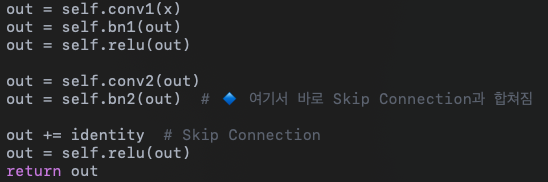  

SE Block 추가한 구조 (SENet)  
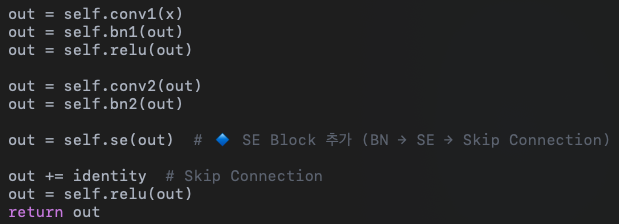  

왜 SE Block을 BN과 Skip Connection 사이에 넣는가?


	- BN(Batch Normalization) 이후 SE Block 적용
	- BN을 거친 후, SE Block을 통해 채널별 가중치를 학습하여 강조할 특징을 조정
	- Skip Connection 이전에 적용
	- SE Block이 조정한 특징을 Skip Connection과 더하기 전에 반영하여 더 효과적인 특징 학습이 가능

-> 즉, BN 후 SE Block 적용 후 Skip Connection을 수행하는 것이 가장 일반적인 방식


In [24]:
import torch
import torch.nn as nn

# SE Block 정의 (기능 추가)
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # GAP (채널별 평균값 계산)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction) # 채널 압축(Squeeze)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels) # 채널 복원(Excitation)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        out = self.global_avg_pool(x).view(batch_size, channels)  # GAP 적용
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)  # 채널 중요도 학습 (0~1)
        out = out.view(batch_size, channels, 1, 1)  # [B, C, 1, 1] 형태 변환
        return x * out  # 원본 특징 맵과 곱하기 (채널 강조)

# SE-ResNet Residual Block (SE Block 포함)
# 기존의 BN 이후에 SE Block을 적용
# BN -> SE Block -> Skip Connection
class SENetResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(SENetResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)  # SE Block 추가
        self.downsample = downsample  # downsample이 필요할 경우 적용 (stride=2인 경우)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)  # 입력 차원을 맞춰주기 위해 downsample 적용

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se(out)  # SE Block 적용 (BN → SE → Skip Connection)

        out += identity  # Skip Connection
        out = self.relu(out)
        return out

# SE-Net 전체 모델 (기존 ResNet에서 SE Block만 추가)
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=101):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)  # 🔹 Dropout 추가
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        # downsample 적용: in_channels != out_channels 이면 적용
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))  # downsample 적용
        self.in_channels = out_channels  # 다음 블록을 위해 채널 업데이트

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))  # 동일한 채널 유지

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# SE-Net 모델 정의
def SENet18(num_classes=101):
    return ResNet(SENetResidualBlock, [2, 2, 2, 2], num_classes) # 기존의 ResNet block을 SENetResidualBlock으로 변경


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SENet18(num_classes=101).to(device)


✅ 모델 실행 테스트 성공: torch.Size([32, 101])


**학습 및 검증**

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SE-Net 모델 정의
model = SENet18(num_classes=101).to(device)  # 모델명 수정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 학습 함수 (ResNet과 동일)
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# 검증 함수 (ResNet과 동일)
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# 학습 실행
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# 학습 로그 저장
with open("training_log2.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc"])
    for i in range(num_epochs):
        writer.writerow([i+1, train_losses[i], val_losses[i], train_accuracies[i], val_accuracies[i]])

print("학습 완료 & 로그 저장 완료")

# 테스트 데이터 평가 함수 추가 (ResNet과 동일)
def evaluate_test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# 학습이 끝난 모델을 바로 테스트 데이터에 적용
test_loss, test_acc = evaluate_test(model, test_loader, criterion, device)

print(f"테스트 결과: Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.2f}%")

# 테스트 로그 저장
with open("training_log2.csv", "a", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Test", "", "", "", test_loss, test_acc])

print("테스트 로그 저장 완료 (training_log2.csv)")

Epoch 1/50 | Train Loss: 3.9067 | Train Acc: 20.07% | Val Loss: 3.5656 | Val Acc: 26.89%
Epoch 2/50 | Train Loss: 3.5578 | Train Acc: 24.24% | Val Loss: 3.5222 | Val Acc: 26.31%
Epoch 3/50 | Train Loss: 3.3758 | Train Acc: 26.51% | Val Loss: 3.4720 | Val Acc: 24.80%
Epoch 4/50 | Train Loss: 3.2768 | Train Acc: 27.70% | Val Loss: 3.2798 | Val Acc: 28.75%
Epoch 5/50 | Train Loss: 3.1844 | Train Acc: 29.51% | Val Loss: 3.1579 | Val Acc: 27.59%
Epoch 6/50 | Train Loss: 3.1373 | Train Acc: 29.68% | Val Loss: 3.1334 | Val Acc: 31.32%
Epoch 7/50 | Train Loss: 3.0562 | Train Acc: 31.37% | Val Loss: 3.1843 | Val Acc: 28.87%
Epoch 8/50 | Train Loss: 2.9749 | Train Acc: 32.10% | Val Loss: 3.1455 | Val Acc: 28.29%
Epoch 9/50 | Train Loss: 2.9405 | Train Acc: 32.24% | Val Loss: 2.9594 | Val Acc: 34.46%
Epoch 10/50 | Train Loss: 2.8677 | Train Acc: 33.10% | Val Loss: 2.9212 | Val Acc: 34.81%
Epoch 11/50 | Train Loss: 2.7934 | Train Acc: 34.75% | Val Loss: 2.9146 | Val Acc: 31.55%
Epoch 12/50 | Train

**훈련 및 검증 결과 비교**

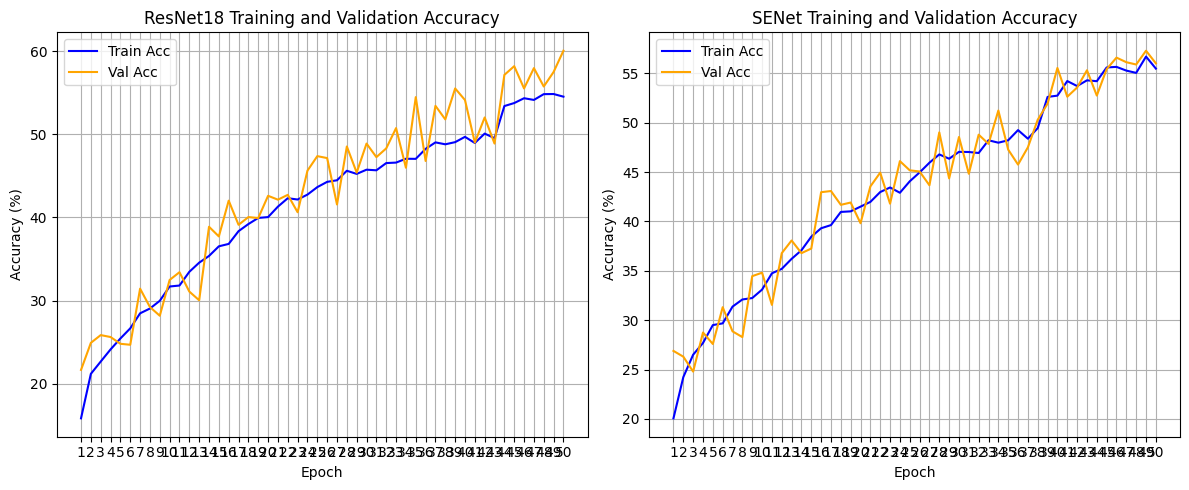

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

file_path1 = "training_log1.csv"
file_path2 = "training_log2.csv"

df1 = pd.read_csv(file_path1, usecols=["Epoch", "Train Acc", "Val Acc"]).iloc[:50]
df2 = pd.read_csv(file_path2, usecols=["Epoch", "Train Acc", "Val Acc"]).iloc[:50]

# 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 그래프

# ResNet18 그래프
axes[0].plot(df1["Epoch"], df1["Train Acc"], label="Train Acc", color="blue")
axes[0].plot(df1["Epoch"], df1["Val Acc"], label="Val Acc", color="orange")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("ResNet18 Training and Validation Accuracy")
axes[0].legend()
axes[0].grid()

# SENet 그래프
axes[1].plot(df2["Epoch"], df2["Train Acc"], label="Train Acc", color="blue")
axes[1].plot(df2["Epoch"], df2["Val Acc"], label="Val Acc", color="orange")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("SENet Training and Validation Accuracy")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

1. ResNet18 (왼쪽 그래프)


	- Train Accuracy(파란색): 점진적으로 증가하며 약 54~55% 수준에서 수렴
	- Validation Accuracy(주황색): 훈련보다 조금 높게 형성되며 60% 근처까지 도달
	- 특징:
	    - 초반에는 훈련과 검증 정확도 차이가 컸지만, 후반부로 갈수록 좁혀짐
	    - 검증 정확도의 변동이 크며, 과적합 가능성을 조금 보임

2. SENet (오른쪽 그래프)


	- Train Accuracy(파란색): 점진적으로 증가하며 56% 이상으로 상승
	- Validation Accuracy(주황색): 약 58~59% 수준에서 안정화
	- 특징:
	    - 훈련과 검증 정확도가 거의 비슷한 경향
	    - 변동성이 상대적으로 적어, 모델이 더 안정적으로 학습된 것으로 보임


SENet이 더 높은 Train Accuracy & Validation Accuracy를 달성 → SE Block이 모델 성능 향상에 기여

SENet의 학습 안정성이 높음 → 검증 정확도가 급격히 흔들리지 않고 비교적 부드럽게 증가

ResNet18은 Validation Accuracy 변동이 큼 → 특정 Epoch에서는 Train Accuracy보다 낮아지는 과적합 가능성

결과적으로, SENet이 ResNet18보다 성능이 약간 더 좋고, 안정적으로 학습됨
즉, SE Block이 유용한 특징을 강조하는 효과가 있었다고 판단

**테스트 결과 비교**

In [37]:
import pandas as pd


file_path1 = "training_log1.csv"
file_path2 = "training_log2.csv"

# 마지막 줄만 읽기
with open(file_path1, "r") as f:
    last_line1 = f.readlines()[-1].strip().split(",")  # 마지막 줄 읽고 쉼표로 분할

with open(file_path2, "r") as f:
    last_line2 = f.readlines()[-1].strip().split(",")  # 마지막 줄 읽고 쉼표로 분할

# 마지막 열 값 추출 (테스트 정확도)
test_acc1 = float(last_line1[-1])  # ResNet 테스트 정확도
test_acc2 = float(last_line2[-1])  # SENet 테스트 정확도

# 결과 출력
print(f"ResNet Test Accuracy: {test_acc1:.2f}%")
print(f"SENet Test Accuracy: {test_acc2:.2f}%")

ResNet Test Accuracy: 59.93%
SENet Test Accuracy: 55.32%
